In [1]:
import argparse
import copy
import random
import tqdm
import json
import numpy as np

import gymnasium as gym
import torch
import torch.nn as nn

import memory
from memory import Transition
import networks
from utils import np_to_unsq_tensor, squeeze_np
from experiment_utils import Plot

In [2]:
start = 1 / np.log(0.01) 
# start = 1 / np.log(0.99) # with 1 gamma
end = 1 / np.log(0.99)   
gammas = torch.exp(torch.true_divide(1, torch.linspace(start, end, 10)))

In [3]:
gammas

tensor([0.0100, 0.9149, 0.9561, 0.9704, 0.9777, 0.9821, 0.9851, 0.9872, 0.9888,
        0.9900])

In [20]:
num_episode = 100
num_gamma = 10
model_reward_hist = [[] for _ in range(num_gamma)]

for ep in range(num_episode):
    for gam in range(num_gamma):
        model_reward_hist[gam].append(5)
        

In [21]:


qq = np.array([model_reward_hist[i] for i in range(num_gamma)])



In [23]:
qq.shape

(10, 100)

In [24]:
import torch

def moving_average(time_series, window_size=20):
    # Initialize the list with zeros for the first 100 elements
    averaged_series = [0] * min(window_size, len(time_series))
    
    # Compute the moving average for each position in the series
    for i in range(window_size, len(time_series)):
        # Calculate the average of the last 100 elements from the current position
        average = (sum(time_series[i-window_size:i]) / window_size)
        if type(average) == type(torch.tensor([0])):
            average = average.item()
        averaged_series.append(average)
    
    return averaged_series

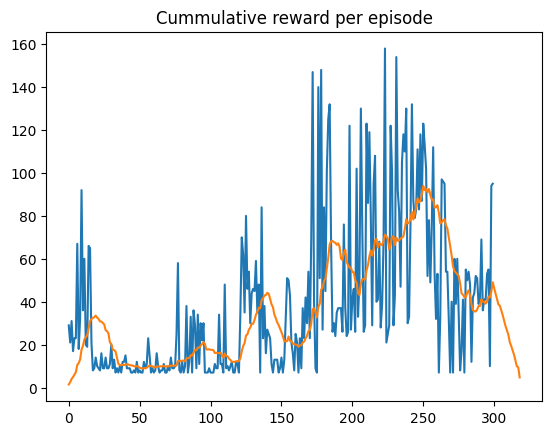

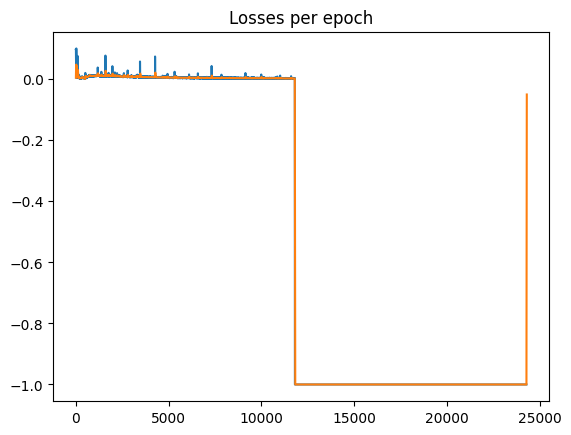

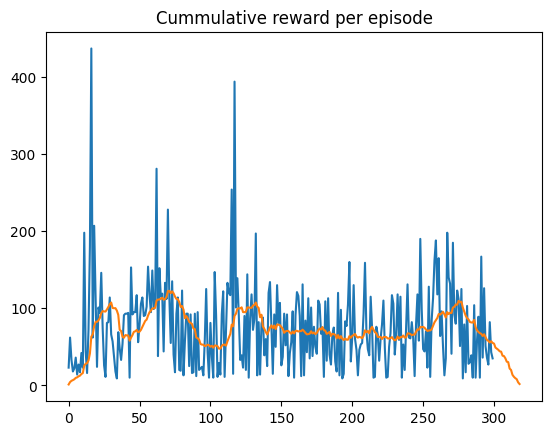

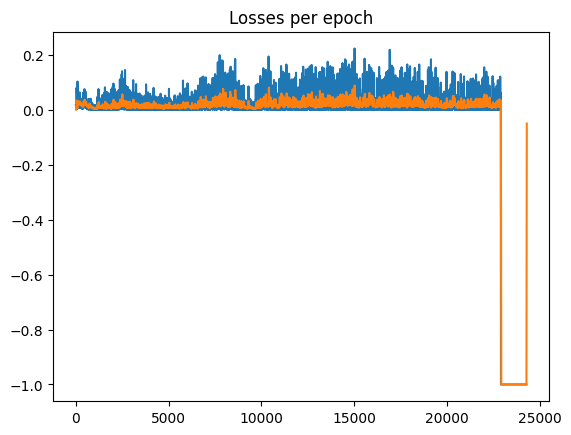

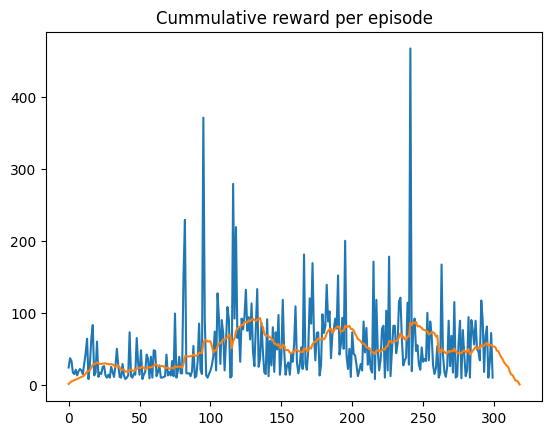

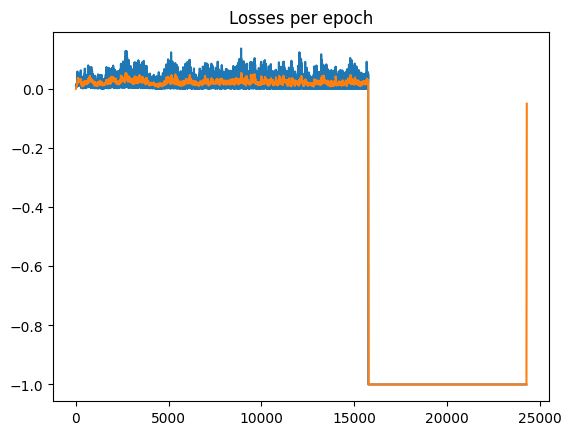

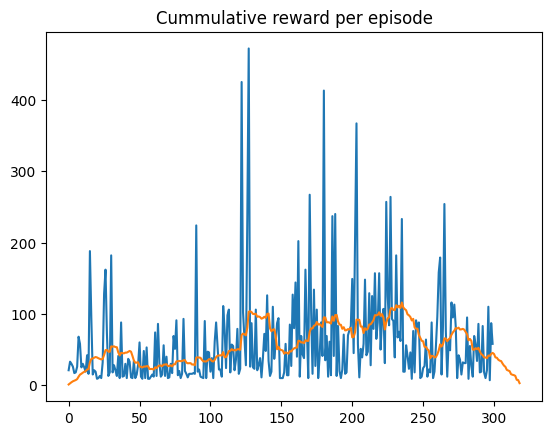

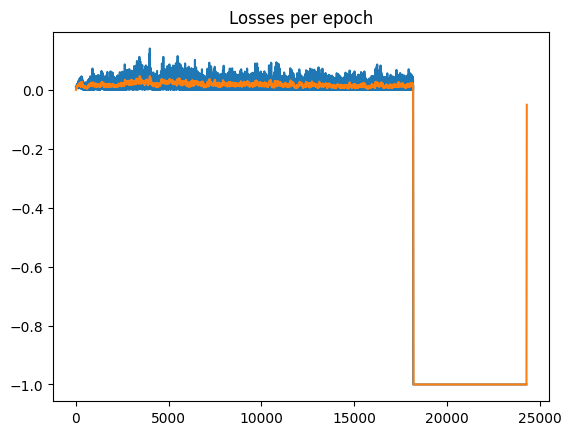

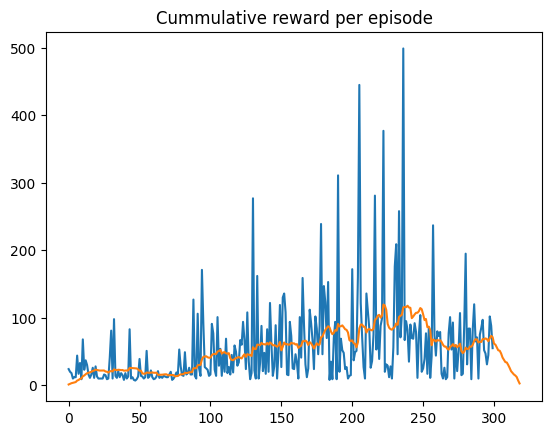

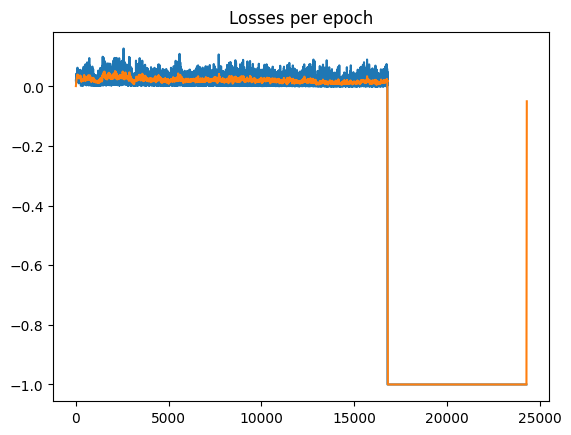

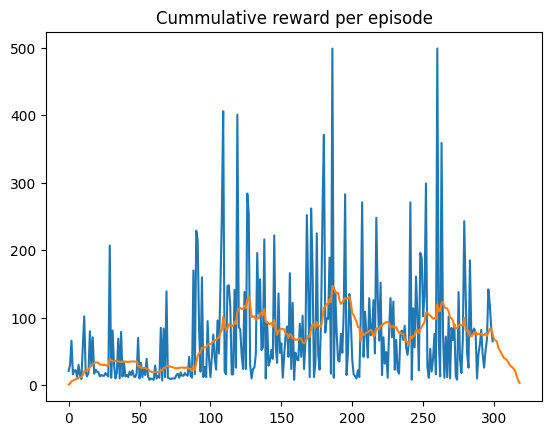

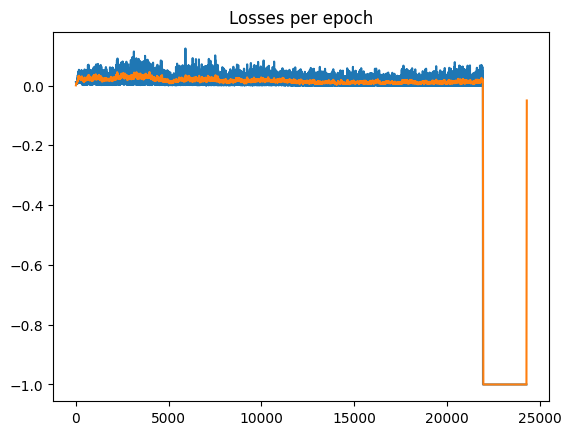

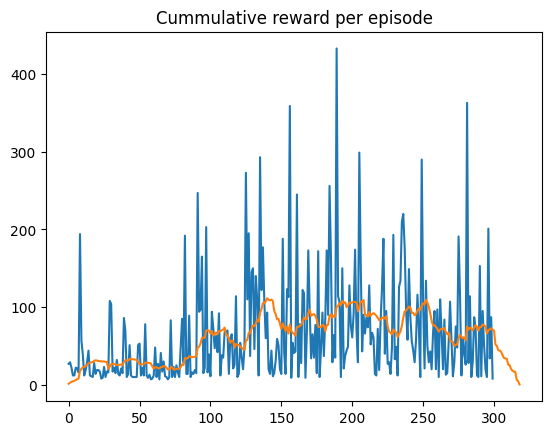

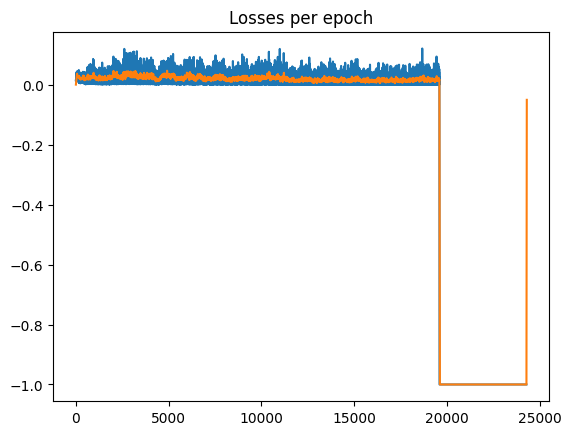

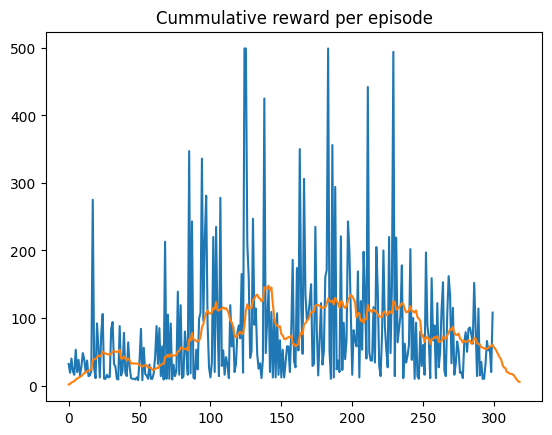

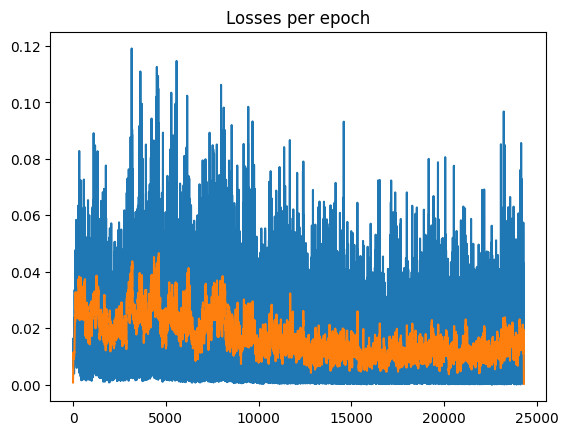

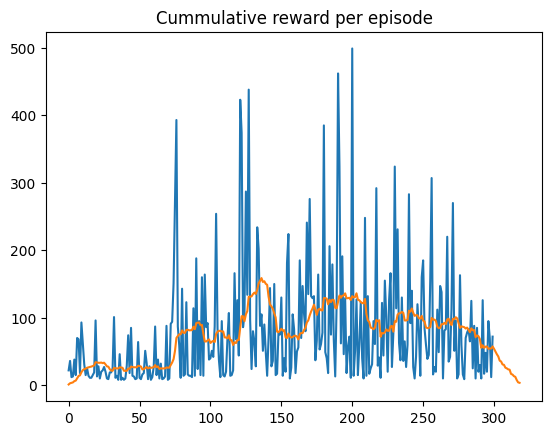

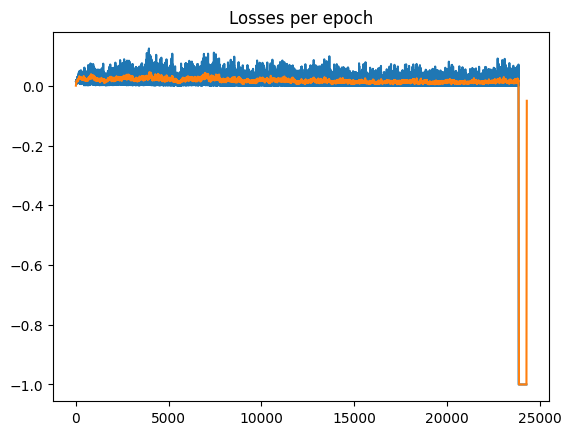

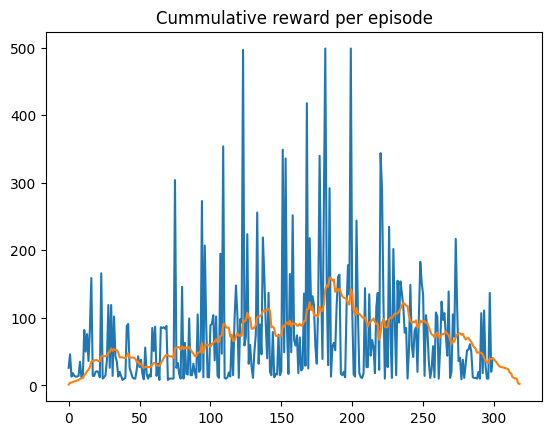

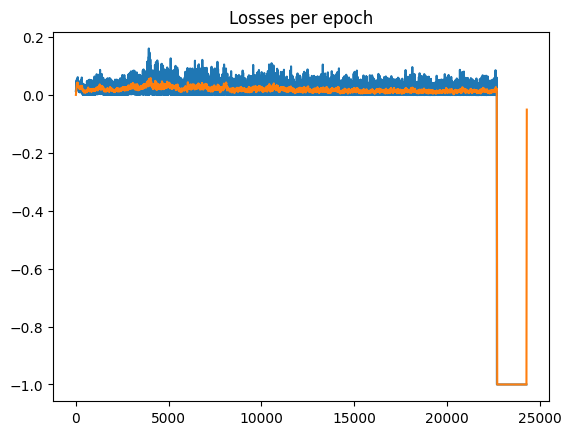

In [99]:
import numpy as np
import matplotlib.pyplot as plt

rewards_arr = np.load("reward_laplace.npy")
losses_arr = np.load("losses_laplace.npy", allow_pickle=True)
losses_arr[losses_arr==-1] = 0
# unpacking the elements of losses that are numpy arrays
#losses = [loss[0] for loss in losses]




for i in range(rewards_arr.shape[0]):
    rewards = rewards_arr[i]
    losses = losses_arr[i]

    window_size = 20
    kernel = np.ones(window_size) / window_size
    reward_average = np.convolve(rewards.squeeze(), kernel, mode='full')

    plt.plot(rewards)
    plt.plot(reward_average)
    plt.title("Cummulative reward per episode")
    plt.show()
    


    loss_average = np.convolve(losses.squeeze(), kernel, mode='full')
    plt.plot(losses)
    plt.plot(loss_average)
    plt.title("Losses per epoch")
    plt.show()

In [103]:
losses_arr[losses_arr==-1] = 0

45059

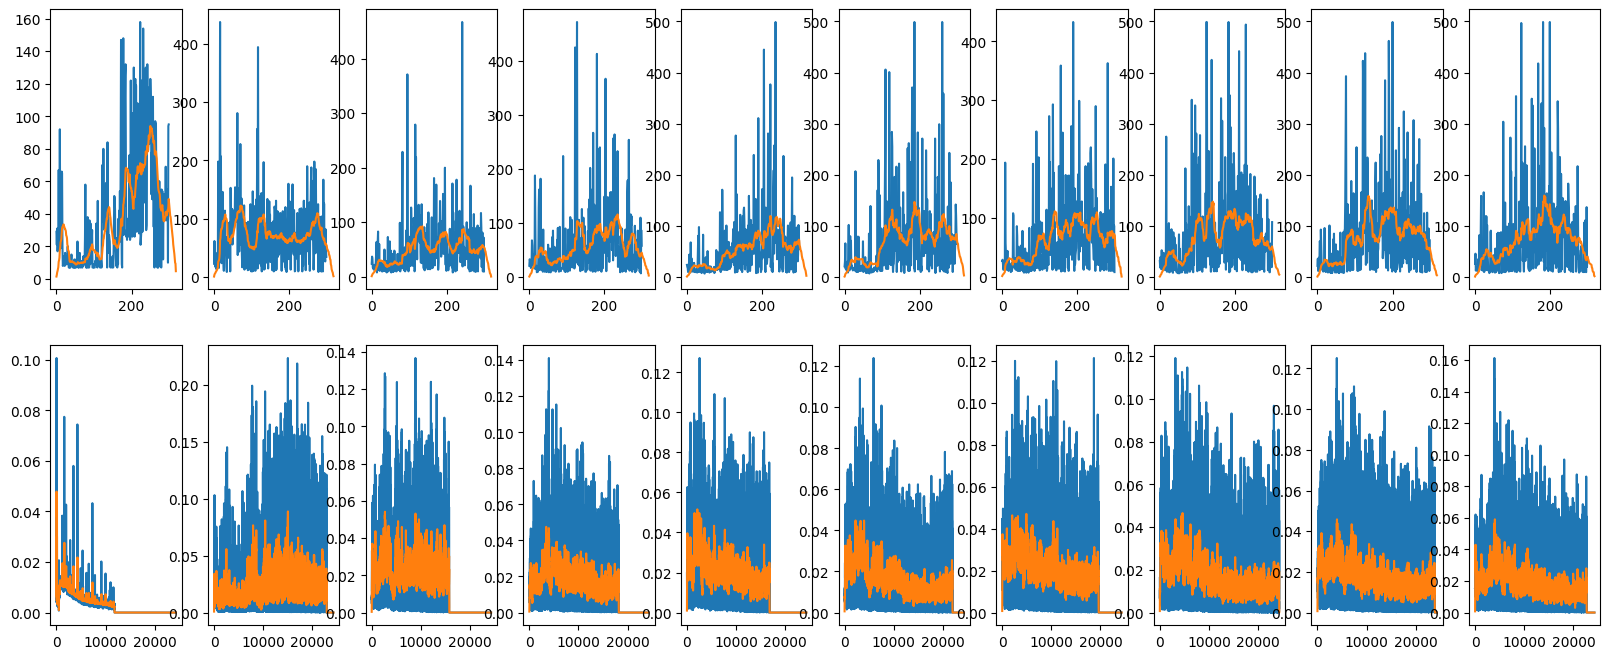

In [107]:
import numpy as np
import matplotlib.pyplot as plt

rewards_arr = np.load("reward_laplace.npy")
losses_arr = np.load("losses_laplace.npy", allow_pickle=True)
losses_arr[losses_arr==-1] = 0
# unpacking the elements of losses that are numpy arrays
#losses = [loss[0] for loss in losses]

n = losses_arr.shape[0]
fig, axes = plt.subplots(2, n, figsize=(20,8))


for i in range(rewards_arr.shape[0]):
    rewards = rewards_arr[i]
    losses = losses_arr[i]

    window_size = 20
    kernel = np.ones(window_size) / window_size
    reward_average = np.convolve(rewards.squeeze(), kernel, mode='full')

    axes[0, i].plot(rewards)
    axes[0, i].plot(reward_average)
    
    loss_average = np.convolve(losses.squeeze(), kernel, mode='full')
    axes[1, i].plot(losses)
    axes[1, i].plot(loss_average)


plt.show()

In [104]:
losses_arr.shape

(10, 24280)

In [38]:
rewards = rewards_arr[i]
losses = losses_arr[i]

reward_average = moving_average(rewards)
loss_average = moving_average(losses, window_size=100)


In [46]:
moving_average(rewards)

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 array([19.65], dtype=float32),
 array([23.4], dtype=float32),
 array([26.45], dtype=float32),
 array([28.1], dtype=float32),
 array([32.7], dtype=float32),
 array([33.15], dtype=float32),
 array([35.1], dtype=float32),
 array([38.1], dtype=float32),
 array([38.1], dtype=float32),
 array([38.65], dtype=float32),
 array([38.5], dtype=float32),
 array([40.55], dtype=float32),
 array([42.], dtype=float32),
 array([42.6], dtype=float32),
 array([43.75], dtype=float32),
 array([46.75], dtype=float32),
 array([48.], dtype=float32),
 array([48.65], dtype=float32),
 array([52.1], dtype=float32),
 array([53.4], dtype=float32),
 array([56.8], dtype=float32),
 array([54.4], dtype=float32),
 array([52.2], dtype=float32),
 array([50.], dtype=float32),
 array([46.75], dtype=float32),
 array([47.05], dtype=float32),
 array([48.3], dtype=float32),
 array([46.7], dtype=float32),
 array([49.8], dtype=float32),
 array([52.15]

In [55]:
# -*- coding:utf-8 -*-
from replay_memory import ReplayMemory, Transition
from reproducibility import set_seed
import numpy as np
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from collections import deque
from LaplaceDQN_net import *
from itertools import count
import random
import math
import torch

import gym
# from config import Config


In [77]:
# from config import Config
from reproducibility import set_seed
from DQN import DQNAgent
# from LaplaceDQN_multgam import LaplaceDQNAgentMultgam

import gym

In [95]:
import torch 

# TODO add a parameter for class initialisation for the type of game 
# and automatically extract environment parameters -> for now setup 
# for CartPole environment
class Config:
    def __init__(self, env):
        # environment parameters
        self.action_dim = env.action_space.n
        # Get the number of state observations
        state, _ = env.reset()
        self.input_dim = len(state)

        self.num_episodes = 15
        self.evaluate_episodes = 10
        # note that OpenAI gym has max environment steps (e.g. max_step = 200 for CartPole)
        self.steps = 500 # Note this may have changed to 500 TODO (check)
        self.replay_buffer_size = 10000

        # Hyperparameters
        self.BATCH_SIZE = 128
        self.GAMMA = 0.99
        self.EPS_START = 0.9 # 0.9 if not pre-trained weights
        self.EPS_END = 0.05
        self.EPS_DECAY = 1000
        self.TAU = 0.05
        self.LR = 1e-3

        # reproducibility 
        self.seed = 42

        # Neural network parameters
        # define optimizer in the Neural net class? TODO optimizer = optim.AdamW(policy_net.parameters(), lr=LR, amsgrad=True)
        # NOTE: In the original DRL repo implemented with tensorflow there are:
        # 1) checkpoints which basically periodically saves the model weights during training 
        # e.g., whenever the model improves 
        #     def save_model_checkpoint(epoch, model, filepath='harvey.pth'):
        #          torch.save(model.state_dict(), filepath)
        # 2) Early stopping: this can be implemented with a EarlyStopping class for example

        # if GPU is to be used
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        # -----------------------------------------------------------------------
        #                Specilaized Parameters for each DRL Algorithm 
        # -----------------------------------------------------------------------

        # Categorical DQN parameters
        self.categorical_Vmin = 0
        self.categorical_Vmax = 100
        self.categorical_n_atoms = 51

        # Quantile Regression DQN parameters
        self.num_quantiles = 20 
        self.huber_loss_threshold = 1
        
        # Expetile ER-DQN parameters
        self.num_expectiles = 10 
        self.z_val_limits = (0, 10) # NOTE change depending on the environment?
        self.num_imputed_samples = 10
        self.imputation_distribution_bounds = tuple(self.z_val_limits for _ in range(self.num_imputed_samples))
        self.imputation_method = "root"  # root or minimization

        # Imputation used to reconstruct a distribution from its distribution statistics e.g., quatiles 
        # Introduced in the general DRL framework "Statistics and Samples in Distributional Reinforcement Learning"
        # the default root method is "hybr", it requires the input shape of x to be the same as
        # the output shape of the root results
        # in this case, it means that the imputed sample size to be exactly the same
        # as the number of expectiles
        # this is also the assumption in the paper if you look closely at Algorithm 2 and appendix D.1
        if self.imputation_method == "root":
            assert self.num_expectiles == self.num_imputed_samples, \
                "if you use root method, the number of imputed samples must be equal to the number of expectiles"
        
        # Laplace Code parameters
        self.num_gamma = 10
        self.num_sensitivities = 3
        self.rmin = 0
        self.rmax = 2 
        self.learning_rate = 0.1  # not using neural networks for now
        self.alpha = 1 # Regularization parameter for SVD-based Discrete Linear Decoder



In [96]:

model_loss_hist = [[] for _ in range(num_gamma)]

class LaplaceDQNAgentMultgam:

    def __init__(self, game):
        env = gym.make(game, None)
        config = Config(env)

        self.envs = [env] + [gym.make(game, None) for _ in range(config.num_gamma-1)]
        for env in self.envs:
            env.action_space.seed(config.seed)
        
        self.config = config 
        self.input_dim = config.input_dim
        self.action_dim = config.action_dim

        self.num_episodes = config.num_episodes
        self.steps = config.steps
        self.BATCH_SIZE = config.BATCH_SIZE
        #self.GAMMA = config.GAMMA
        self.LR = config.LR
        self.TAU = config.TAU
        self.device = config.device

        self.num_sensitivities = config.num_sensitivities 
        self.rmin = config.rmin
        self.rmax = config.rmax
        self.sensitivity_step = (self.rmax - self.rmin) / self.num_sensitivities
        self.sensitivities = torch.arange(self.rmin, self.rmax, self.sensitivity_step)
        self.middle_sensitivities = torch.tensor([torch.true_divide(self.sensitivities[i] + self.sensitivities[i+1], 2) for i in range(self.sensitivities.shape[0]-1)])
        
        self.num_gamma = config.num_gamma 
        print("DEBUG: num Gamma", self.num_gamma)
        start = 1 / np.log(0.01) 
        # start = 1 / np.log(0.99) # with 1 gamma
        end = 1 / np.log(0.99)   
        self.gammas = torch.exp(torch.true_divide(1, torch.linspace(start, end, self.num_gamma)))
        
        self.total_steps = [0 for _ in range(self.num_gamma)]

        # reproducibility
        self.seed = config.seed
        set_seed(self.seed)

        # self.env = None
        # copying weights of base_net to policy_net and target_net
        self.policy_net = DQNNetMultgam(self.config)
        self.target_net = DQNNetMultgam(self.config)
        self.target_net.load_state_dict(self.policy_net.state_dict())
        self.optimizer = optim.AdamW(self.policy_net.parameters(), lr=self.LR, amsgrad=True)
        self.criterion = nn.SmoothL1Loss()

        self.replay_buffer_size = config.replay_buffer_size
        self.replay_memory = [ReplayMemory(self.replay_buffer_size) for _ in range(self.num_gamma)] 
        # have a replay buffer for every gamma (leads to different policies for each)
        #self.replay_buffers = [ReplayMemory(self.replay_buffer_size) for _ in range(self.num_gamma)]
        
        self.episode_durations = []
        self.check_model_improved = [torch.tensor([0]) for _ in range(self.num_gamma)]
        self.best_max = [torch.tensor([0]) for _ in range(self.num_gamma)]

        # for select action (epsilon-greedy)
        self.steps_done = [0 for _ in range(self.num_gamma)]
        
        # save for plotting evolution during training for each gamma
        self.model_reward_hist = [[] for _ in range(self.num_gamma)]
        
    
    def transition(self):
        """
        In transition, the agent simply plays and records
        [current_state, action, reward, next_state, done]
        in the replay_memory

        Updating the weights of the neural network happens
        every single time the replay buffer size is reached.

        done: boolean, whether the game has ended or not.
        """
        
        # multiple environments for every gamma
        # self.envs = [self.env] * self.num_gamma
        self.states = [torch.from_numpy(env.reset(seed=self.seed)[0]).float().unsqueeze(0) for env in self.envs] 
            
        for i_episode in range(self.num_episodes):
            #state, info = self.env.reset(seed=self.seed) # for 1 gammas
            #state = torch.tensor(state, dtype=torch.float32, device=self.device).unsqueeze(0)


            for gamma_idx, gamma in enumerate(self.gammas):
                print('Episode: {} Reward: {} Max_Reward: {}'.format(i_episode, self.check_model_improved[gamma_idx].item(), self.best_max[gamma_idx].item()))
                print('-' * 64)
                self.check_model_improved[gamma_idx] = 0
                # print("DEBUG in transitions: ", t)
                for t in count():    
                    env = self.envs[gamma_idx]
                    state = self.states[gamma_idx]
                    
                    action = self.select_action(gamma_idx) 
                    observation, reward, terminated, truncated, _ = env.step(action.item())
                    reward = torch.tensor([reward], device=self.device)
                    # print("DEBUG Done terminated, truncated", terminated, truncated)
                    done = terminated or truncated

                    if terminated:
                        next_state = None
                    else:
                        next_state = torch.tensor(observation, dtype=torch.float32, device=self.device).unsqueeze(0)

                    # Store the transition in memory
                    self.replay_memory[gamma_idx].push(state, action, next_state, reward)

                    # Move to the next state
                    self.states[gamma_idx] = next_state
                    #state = next_state 
                    self.total_steps[gamma_idx] += 1

                    # Perform one step of the optimization (on the policy network)
                    self.train_by_replay(gamma_idx) 

                    # Soft update of the target network's weights 
                    # θ′ ← τ θ + (1 −τ )θ′
                    # previous implementation updates were done for any episode where the reward is higher
                    target_net_state_dict = self.target_net.state_dict()
                    policy_net_state_dict = self.policy_net.state_dict()
                    for key in policy_net_state_dict:
                        target_net_state_dict[key] = policy_net_state_dict[key]*self.TAU + target_net_state_dict[key]*(1-self.TAU)
                    self.target_net.load_state_dict(target_net_state_dict)

                    if done:
                        self.episode_durations.append(t + 1)
                        self.model_reward_hist[gamma_idx].append(self.check_model_improved[gamma_idx].detach().numpy())
                        self.states[gamma_idx] = torch.from_numpy(self.envs[gamma_idx].reset(seed=self.seed)[0]).float().unsqueeze(0)
                        break # can't break anymore -> need to reset to not have all episodes restart TODO
                    else:
                        self.check_model_improved[gamma_idx] += reward

                if self.check_model_improved[gamma_idx] > self.best_max[gamma_idx]:
                    self.best_max[gamma_idx] = self.check_model_improved[gamma_idx]
                
        # Save the losses and rewards to numpy arrays
        cum_reward_per_episode = np.array([self.model_reward_hist[i] for i in range(self.num_gamma)])
        np.save('reward_laplace.npy', cum_reward_per_episode)

        vectors = model_loss_hist
        max_length = max(len(vec) for vec in vectors)
        padded_vectors = [np.pad(vec, (0, max_length - len(vec)), 'constant', constant_values=-1) for vec in vectors]
        loss_result = np.vstack(padded_vectors)

        np.save('losses_laplace.npy', loss_result) # check if I can save a numpy array of lists
        torch.save(self.policy_net.state_dict(), "policy_net_weights_laplace.pth")
        torch.save(self.target_net.state_dict(), "target_net_weights_laplace.pth")
        
    # for multiple gammas 
    def train_by_replay(self, gamma_idx):
        """
        TD update by replaying the history.
        """
        # step 1: generate replay samples (size = self.batch_size) from the replay buffer
        # e.g. uniform random replay or prioritize experience replay
        if len(self.replay_memory[gamma_idx]) < self.BATCH_SIZE:
            return
        transitions = self.replay_memory[gamma_idx].sample(self.BATCH_SIZE)

        # Transpose the batch (see https://stackoverflow.com/a/19343/3343043 for
        # detailed explanation). This converts batch-array of Transitions
        # to Transition of batch-arrays.
        batch = Transition(*zip(*transitions))

        # Compute a mask of non-final states and concatenate the batch elements
        # (a final state would've been the one after which simulation ended)
        non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                            batch.next_state)), device=self.device, dtype=torch.bool)
        non_final_next_states = torch.cat([s for s in batch.next_state
                                                    if s is not None])
        state_batch = torch.cat(batch.state)
        action_batch = torch.cat(batch.action)
        reward_batch = torch.cat(batch.reward)

        # Compute Q(s_t, a) - the model computes Q(s_t), then we select the
        # columns of actions taken. These are the actions which would've been taken
        # for each batch state according to policy_net
        input = torch.cat((state_batch, torch.tensor([self.gammas[gamma_idx]]).unsqueeze(0).repeat(state_batch.shape[0], 1)), dim=1)  
        assert state_batch.shape[0] == input.shape[0]
        output = self.policy_net(input) 
        state_action_values = output[torch.arange(output.size(0)), action_batch.squeeze()]
        
        # Compute V(s_{t+1}) for all next states.
        # Expected values of actions for non_final_next_states are computed based
        # on the "older" target_net; selecting their best reward with max(1).values
        # This is merged based on the mask, such that we'll have either the expected
        # state value or 0 in case the state was final.
        next_output = torch.zeros(self.BATCH_SIZE, self.action_dim, self.num_sensitivities, device=self.device) # for 1 sensitivity 
        with torch.no_grad():
            next_inputs = torch.cat((non_final_next_states, torch.tensor([self.gammas[gamma_idx]]).unsqueeze(0).repeat(non_final_next_states.shape[0], 1)), dim=1) 
            next_output[non_final_mask] = self.target_net(next_inputs)
            action_values = torch.sum((next_output[:, :, :-1] - next_output[:, :, 1:]) * self.middle_sensitivities, dim=2)
            max_action_values = action_values.max(1).indices
            next_state_values = next_output[torch.arange(next_output.size(0)), max_action_values]        
        
        rewards_thresh = torch.nn.functional.sigmoid(reward_batch.unsqueeze(-1).repeat(1, self.sensitivities.shape[0])-self.sensitivities.unsqueeze(0).repeat(reward_batch.shape[0], 1))
        
        assert torch.all((rewards_thresh <= 1) & (rewards_thresh >= 0)), "Rewards after activation should be between 0 or 1"
        
        # Compute the expected Q values 
        expected_state_action_values = (next_state_values * self.gammas[gamma_idx]) + rewards_thresh 
        
        # Compute Huber loss
        loss = self.criterion(state_action_values, expected_state_action_values) / float(self.num_gamma)
        model_loss_hist[gamma_idx].append(loss.detach().numpy())
        
        # Optimize the model
        self.optimizer.zero_grad()
        loss.backward()
        # In-place gradient clipping
        torch.nn.utils.clip_grad_value_(self.policy_net.parameters(), 100)
        self.optimizer.step()


    def select_action(self, gamma_idx):
        
        sample = random.random()
        eps_threshold = self.config.EPS_END + (self.config.EPS_START - self.config.EPS_END) * \
            math.exp(-1. * self.steps_done[gamma_idx] / self.config.EPS_DECAY)
        self.steps_done[gamma_idx] += 1

        if sample > eps_threshold:
            with torch.no_grad():
                input = torch.cat((self.states[gamma_idx], torch.tensor([self.gammas[gamma_idx]]).unsqueeze(0)), dim=1)
                
                assert self.states[gamma_idx].shape[0] == input.shape[0]
                
                z = self.policy_net(input) 
                action_values = torch.sum((z[:, :, :-1] - z[:, :, 1:]) * self.middle_sensitivities, dim=2) 
                
                assert action_values.shape[0] == self.states[gamma_idx].shape[0]
                
                # t.max(1) will return the largest column value of each row.
                # second column on max result is index of where max element was
                # found, so we pick action with the larger expected reward.
                return action_values.max(1).indices.view(1, 1)
        else:
            return torch.tensor([[self.envs[gamma_idx].action_space.sample()]], device=self.device, dtype=torch.long)
        

In [97]:


game = 'CartPole-v1'

dqn_agent = LaplaceDQNAgentMultgam(game)
# dqn_agent.env = env

dqn_agent.transition()
print("finish training")
print('=' * 64)
print("evaluating.....")
dqn_agent.eval_step(render=True)

DEBUG: num Gamma 10
Episode: 0 Reward: 0 Max_Reward: 0
----------------------------------------------------------------
Episode: 0 Reward: 0 Max_Reward: 0
----------------------------------------------------------------
Episode: 0 Reward: 0 Max_Reward: 0
----------------------------------------------------------------
Episode: 0 Reward: 0 Max_Reward: 0
----------------------------------------------------------------
Episode: 0 Reward: 0 Max_Reward: 0
----------------------------------------------------------------
Episode: 0 Reward: 0 Max_Reward: 0
----------------------------------------------------------------
Episode: 0 Reward: 0 Max_Reward: 0
----------------------------------------------------------------
Episode: 0 Reward: 0 Max_Reward: 0
----------------------------------------------------------------
Episode: 0 Reward: 0 Max_Reward: 0
----------------------------------------------------------------


/Users/alpayozkan/opt/anaconda3/envs/distrl_proj/lib/python3.11/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


Episode: 0 Reward: 0 Max_Reward: 0
----------------------------------------------------------------
Episode: 1 Reward: 29.0 Max_Reward: 29.0
----------------------------------------------------------------
Episode: 1 Reward: 23.0 Max_Reward: 23.0
----------------------------------------------------------------
Episode: 1 Reward: 24.0 Max_Reward: 24.0
----------------------------------------------------------------
Episode: 1 Reward: 21.0 Max_Reward: 21.0
----------------------------------------------------------------
Episode: 1 Reward: 24.0 Max_Reward: 24.0
----------------------------------------------------------------
Episode: 1 Reward: 21.0 Max_Reward: 21.0
----------------------------------------------------------------
Episode: 1 Reward: 27.0 Max_Reward: 27.0
----------------------------------------------------------------
Episode: 1 Reward: 32.0 Max_Reward: 32.0
----------------------------------------------------------------
Episode: 1 Reward: 22.0 Max_Reward: 22.0
-----------

AttributeError: 'LaplaceDQNAgentMultgam' object has no attribute 'eval_step'

In [89]:
        
        
        loss_result = np.vstack(padded_vectors)

3703

In [93]:
max_length = max(len(vec) for vec in model_loss_hist)
max_length

535

In [94]:
padded_vectors = [np.pad(vec, (0, max_length - len(vec)), 'constant', constant_values=-1) for vec in vectors]

ValueError: index can't contain negative values

In [92]:
print(len(model_loss_hist))
print([len(r) for r in model_loss_hist])

10
[442, 535, 269, 342, 261, 343, 443, 328, 419, 349]


In [86]:
np.array(model_loss_hist).shape

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (10,) + inhomogeneous part.

In [63]:
np.array(model_loss_hist)

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (10,) + inhomogeneous part.

In [66]:
len(model_loss_hist)

10

In [68]:
[len(l) for l in model_loss_hist]

[894, 3703, 1182, 1826, 1003, 1512, 1384, 1761, 1361, 1824]

In [72]:
vectors = model_loss_hist

max_length = max(len(vec) for vec in vectors)
max_length

3703

In [75]:
padded_vectors = [np.pad(vec, (0, max_length - len(vec)), 'constant', constant_values=-1) for vec in vectors]
[len(l) for l in padded_vectors]

[3703, 3703, 3703, 3703, 3703, 3703, 3703, 3703, 3703, 3703]

In [76]:
result = np.vstack(padded_vectors)
result.shape

(10, 3703)

In [ ]:
max_length = max(len(vec) for vec in model_loss_hist)
padded_vectors = [np.pad(vec, (0, max_length - len(vec)), 'constant', constant_values=-1) for vec in vectors]
result = np.vstack(padded_vectors)

In [ ]:
np.save('losses_laplace.npy', np.array(model_loss_hist)) # check if I can save a numpy array of lists

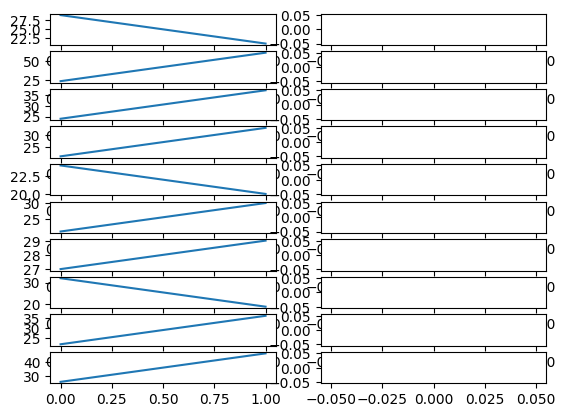

In [34]:
n = rewards.shape[0]

fig, axes = plt.subplots(n, 2)

for i in range(n):
    axes[i, 0].plot(rewards[i])
    axes[i, 1].plot(losses[i])

In [31]:
rewards[0].shape

(2, 1)

In [32]:
rewards.shape

(10, 2, 1)

In [ ]:
rewards.shape

In [27]:
losses.shape

(10, 0)

In [29]:
losses

array([], shape=(10, 0), dtype=float64)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

rewards = np.load("rewards.npy")
losses = np.load("losses.npy", allow_pickle=True)
# unpacking the elements of losses that are numpy arrays
#losses = [loss[0] for loss in losses]

reward_average = moving_average(rewards)
loss_average = moving_average(losses, window_size=100)

plt.plot(rewards)
plt.plot(reward_average)
plt.title("Cummulative reward per episode")
plt.show()

plt.plot(losses)
plt.plot(loss_average)
plt.title("Losses per epoch")
plt.show()

In [19]:
qq.shape

(10, 100, 2)

In [17]:
qq

[array([1, 0]),
 array([1, 0]),
 array([1, 0]),
 array([1, 0]),
 array([1, 0]),
 array([1, 0]),
 array([1, 0]),
 array([1, 0]),
 array([1, 0]),
 array([1, 0])]

In [14]:
len(model_reward_hist[0])

100

IndexError: list index out of range

In [2]:
# refactor into utils if I keep this template
def extract(transitions):
    """Extract tensors of s, a, r, s' from a batch of transitions.

    Args:
        transitions (list): List of Transition named tuples where next_state is None if episode
            ended.

    Returns:
        (states, actions, rewards, next_states, mask) that are all (batch_size, *shape) tensors
        containing the extracted data. next_states does not contain elements for episode that
        ended. mask is a boolean tensor that specifies which transitions have a next state.
    """
    states = torch.cat([t.state for t in transitions])
    actions = torch.cat([t.action for t in transitions])
    rewards = torch.cat([t.reward for t in transitions])
    mask = torch.tensor([t.next_state is not None for t in transitions])
    next_states = torch.cat([t.next_state for t in transitions if t.next_state is not None])
    return states, actions, rewards, next_states, mask

In [3]:
def select_argmax_action(z, middle_sensitivities):
    # Take state-action distribution z, which is a (batch_size, action_size, n_sensitivities)
    # and returns a tensor of shape (batch_size, 1) with the greedy actions for each state
    
    # We want to maximize equation (1) i.e., approximating the expectation over rewards at time t+tau 
    # given state_t and action_t in the definition of the Q-function. 
    # We then select the action by taking the argmax of this Q-function proxy 
    # NOTE the middle sensitivities are akin to atoms in C51

    z = torch.sum((z[:, :, :-1] - z[:, :, 1:]) * middle_sensitivities, dim=2)
    return z.argmax(dim=1).unsqueeze(1)

In [3]:
# parameters

parser = argparse.ArgumentParser()
parser.add_argument('--env', type=str, required=False, default='CartPole-v0',
                    help='Gym environment. Currently supports only Box observation spaces '
                            'and Discrete action spaces. Defaults to CartPole-v0.')
parser.add_argument('--n-sensitivities', type=int, required=False, default=51,
                    help='Number of sensitivities in the distributional network output. '
                            'Defaults to 10.')
parser.add_argument('--n-gammas', type=int, required=False, default=1,
                    help='Number of discount factors used to populate the gamma-space. '
                            'Defaults to 15.')
parser.add_argument('--n-hidden-units', type=int, required=False, default=64,
                    help='Number of hidden units for each layer of the distributional '
                            'network. Defaults to 64.')
parser.add_argument('--n-hidden-layers', type=int, required=False, default=2,
                    help='Number of hidden layers in the distributional network. '
                            'Defaults to 2.')
parser.add_argument('--support-range', type=list, required=False, default=[0, 1],
                    help='Range of the support of rewards. Ideally, it should be [min, max], '
                            'where min and max are referred to the min/max '
                            'reward obtainable at any given time. Defaults to [0, 1].')
parser.add_argument('--start-train-at', type=int, required=False, default=32,
                    help='How many steps to collect before starting training. '
                            'Defaults to 32.')
parser.add_argument('--update-net-every', type=int, required=False, default=5,
                    help='How often to update the target network. Defaults to 5.')
parser.add_argument('--epsilon', type=float, required=False, default=0.1,
                    help='Exploration noise. Defaults to 0.1.')
parser.add_argument('--n-steps', type=int, required=False, default=20000,
                    help='Number of training steps. Defaults to 2000.')
parser.add_argument('--out-file', type=str, required=False, default=None,
                    help='If specified, stores the training plot into the given file. The '
                            'plot is stored as a json object with the keys \'steps\' and '
                            '\'rewards\'.')
args = parser.parse_args(args=[])

    

In [4]:
args

Namespace(env='CartPole-v0', n_sensitivities=51, n_gammas=1, n_hidden_units=64, n_hidden_layers=2, support_range=[0, 1], start_train_at=32, update_net_every=5, epsilon=0.1, n_steps=20000, out_file=None)

In [5]:
env = gym.make(args.env, render_mode=None)
state_dim = env.observation_space.shape[0]

if args.env=='Pendulum-v1':
    act_dim = env.action_space.shape[0]
elif args.env=='CartPole-v0' or args.env=='MountainCar-v0':
    act_dim = env.action_space.n
else:
    raise ValueError('Environment not supported')

n_sensitivities = args.n_sensitivities
n_gammas = args.n_gammas
n_units = args.n_hidden_units
n_layers = args.n_hidden_layers
Z_net = networks.DistributionalNetworkLaplace(inputs=(state_dim + 1), n_actions=act_dim, n_sensitivities=n_sensitivities,
                                            n_hidden_units=n_units, n_hidden_layers=n_layers)
r_min, r_max = args.support_range
start_train_at = args.start_train_at
update_net_every = args.update_net_every
epsilon = args.epsilon
n_steps = args.n_steps

/Users/abelrassat/opt/anaconda3/envs/DRL_proj/lib/python3.12/site-packages/gymnasium/envs/registration.py:513: DeprecationWarning: WARN: The environment CartPole-v0 is out of date. You should consider upgrading to version `v1`.
  logger.deprecation(


In [6]:
# default params

df=0.99
buffer_len=1e6
batch_size=32
lr=0.5e-3
update_mode='hard'
update_every=5
tau=0.05
epsilon=0.1
start_train_at=4000
results_dir=None

In [7]:
Z_net=Z_net
n_sensitivities=n_sensitivities
r_min=r_min
r_max=r_max
n_gammas=n_gammas
n_actions=act_dim
start_train_at=start_train_at
update_every=update_net_every
epsilon=epsilon

In [8]:
Z_net = Z_net
n_sensitivities = n_sensitivities
r_min = r_min
r_max = r_max
n_gammas = n_gammas 
sensitivity_step = (r_max - r_min) / n_sensitivities
n_actions = n_actions
df = df
buffer_len = buffer_len
batch_size = batch_size
update_mode = update_mode
update_every = update_every
tau = tau
epsilon = epsilon
start_train_at = start_train_at
_target_net = copy.deepcopy(Z_net)
optimizer = torch.optim.Adam(Z_net.parameters(), lr=lr)
criterion = nn.SmoothL1Loss()
sensitivities = torch.arange(r_min, r_max, sensitivity_step)
middle_sensitivities = torch.tensor([torch.true_divide(sensitivities[i] + sensitivities[i+1], 2) for i in range(sensitivities.shape[0]-1)])

In [9]:
start = 1 / np.log(0.99)   
end = 1 / np.log(0.99)   
gammas = torch.exp(torch.true_divide(1, torch.linspace(start, end, n_gammas)))

In [10]:
replay_buffers = [memory.TransitionReplayBuffer(maxlen=buffer_len) for _ in range(n_gammas)]

In [11]:
model_reward_hist = []
model_loss_hist = []

In [12]:
def _compute_targets(rewards, next_states, mask, gamma_idx):
    """Compute the target distributions for the given transitions.

    """
    # Predict next state return distribution for each action
    Z_prime = torch.zeros(batch_size, n_actions, n_sensitivities)
    with torch.no_grad():
        input = torch.cat((next_states, torch.tensor([gammas[gamma_idx]]).unsqueeze(0).repeat(next_states.shape[0], 1)), dim=1)
        Z_prime[mask] = _target_net(input) 
    target_actions = select_argmax_action(Z_prime, middle_sensitivities)
    # TODO: Do this with gather or similar
    Z_prime = torch.cat([Z_prime[i, target_actions[i]] for i in range(Z_prime.shape[0])])
    
    # compute the rewards after thresholding
    rewards = (rewards > sensitivities).int()
    assert rewards.shape == (batch_size, n_sensitivities)

    # computing targets 
    Z_target = rewards + gammas[gamma_idx] * Z_prime
    
    return Z_target

def _train_step(step, gamma_idx):
    if step < start_train_at or replay_buffers[gamma_idx].size() < batch_size:
        return
    batch = replay_buffers[gamma_idx].sample(batch_size)
    states, actions, rewards, next_states, mask = extract(batch)
    targets = _compute_targets(rewards, next_states, mask, gamma_idx)
    _train_net(states, actions, targets, gamma_idx, update=(step % update_every) == 0) 

def _train_net(states, actions, targets, gamma_idx, update):
    optimizer.zero_grad()
    input = torch.cat((states, torch.tensor([gammas[gamma_idx]]).unsqueeze(0).repeat(states.shape[0], 1)), dim=1)
    Z = Z_net(input)
    Z = torch.cat([Z[i, actions[i]] for i in range(Z.shape[0])])

    loss = criterion(Z, targets) 
    model_loss_hist.append(loss.item())
    loss.backward()
    optimizer.step()
    if update:
        _update_target_net()

    def _update_target_net():
        # Mode can be 'hard' or 'soft'
        if update_mode == 'hard':
            _target_net.load_state_dict(Z_net.state_dict())
        else:
            for param, target_param in zip(Z_net.parameters(), _target_net.parameters()):
                target_param.copy_(tau * param + (1 - tau) * target_param)



In [13]:
import matplotlib.pyplot as plt

In [15]:
state = [np_to_unsq_tensor(env.reset()[0]) for env in envs]

NameError: name 'envs' is not defined

In [16]:
state[0].shape

NameError: name 'state' is not defined

In [101]:
state = state[gamma_idx]
state.shape

torch.Size([1, 4])

In [14]:
rewards = []
steps = []
episode_rewards = []
envs = [env] * n_gammas
state = [np_to_unsq_tensor(env.reset()[0]) for env in envs]
loop_range = tqdm.tqdm(range(n_steps))
for step in loop_range:
    for gamma_idx, gamma in enumerate(gammas):
        env = envs[gamma_idx]
        state = state[gamma_idx]
                    
        with torch.no_grad():                    
            input = torch.cat((state, torch.tensor([gamma]).unsqueeze(0)), dim=1)
            print(input)
            Z = Z_net(input)
        if random.random() < epsilon:  # Random action
            action = torch.LongTensor([[env.action_space.sample()]])
        else:
            action = select_argmax_action(Z, middle_sensitivities)
        
        next_state, reward, done, _, info = env.step(squeeze_np(action))
        next_state = np_to_unsq_tensor(next_state) if not done else None

        replay_buffers[gamma_idx].remember(
            Transition(state, action, torch.tensor([[reward]]), next_state))
        state[gamma_idx] = next_state

        # Perform training step
        _train_step(step, gamma_idx) 

        # Update episode stats
        episode_rewards.append(reward)

        if done:
            state[gamma_idx] = np_to_unsq_tensor(envs[gamma_idx].reset()[0])
            rewards.append(sum(episode_rewards))
            model_reward_hist.append(sum(episode_rewards))
            steps.append(step)
            episode_rewards = []
            loop_range.set_description(f'Reward {rewards[-1]}')


  0%|          | 0/20000 [00:00<?, ?it/s]

tensor([[-0.0140,  0.0405, -0.0062,  0.0241,  0.9900]])


NameError: name 'select_argmax_action' is not defined

In [87]:
rewards = []
steps = []
episode_rewards = []
envs = [env] * n_gammas
state = [np_to_unsq_tensor(env.reset()[0]) for env in envs]
loop_range = tqdm.tqdm(range(n_steps))

for step in loop_range:
    for gamma_idx, gamma in enumerate(gammas):
        env = envs[gamma_idx]
        state = state[gamma_idx]
                    
        with torch.no_grad():                    
            input = torch.cat((state.reshape(1,-1), torch.tensor([gamma]).unsqueeze(0)), dim=1)
            Z = Z_net(input)
        if random.random() < epsilon:  # Random action
            action = torch.LongTensor([[env.action_space.sample()]])
        else:
            action = select_argmax_action(Z, middle_sensitivities)
        
        next_state, reward, done, _, info = env.step(squeeze_np(action))
        next_state = np_to_unsq_tensor(next_state) if not done else None

        replay_buffers[gamma_idx].remember(
            Transition(state, action, torch.tensor([[reward]]), next_state))
        state[gamma_idx] = next_state

        # Perform training step
        _train_step(step, gamma_idx) 

        # Update episode stats
        episode_rewards.append(reward)

        if done:
            state[gamma_idx] = np_to_unsq_tensor(envs[gamma_idx].reset()[0])
            
            rewards.append(sum(episode_rewards))
            model_reward_hist.append(sum(episode_rewards))

            steps.append(step)
            episode_rewards = []
            loop_range.set_description(f'Reward {rewards[-1]}')

            print('reward:', rewards[-1])
# np.save('rewards.npy', model_reward_hist)
# np.save('losses.npy', model_loss_hist)
# torch.save(Z_net.state_dict(), "policy_net_weights.pth")
# torch.save(_target_net.state_dict(), "target_net_weights.pth")
# return Plot(steps, rewards, None)

  0%|          | 1/20000 [00:00<07:02, 47.29it/s]


RuntimeError: expand(torch.FloatTensor{[4]}, size=[]): the number of sizes provided (0) must be greater or equal to the number of dimensions in the tensor (1)

In [93]:
state[gamma_idx] = next_state

RuntimeError: expand(torch.FloatTensor{[4]}, size=[]): the number of sizes provided (0) must be greater or equal to the number of dimensions in the tensor (1)

In [89]:
gamma_idx

0

In [91]:
state[0]

tensor(0.0375)

In [92]:
state[gamma_idx]

tensor(0.0375)

In [95]:
next_state

tensor([[ 0.0410,  0.3711, -0.0524, -0.6379]])

In [96]:
next_state.shape

torch.Size([1, 4])

In [86]:
input = torch.cat((state.reshape(1,-1), torch.tensor([gamma]).unsqueeze(0)), dim=1)
Z = Z_net(input)

In [85]:
print(state.shape)
print(state.reshape(-1,1).shape)

print(torch.tensor([gamma]).shape)
print(torch.tensor([gamma]).unsqueeze(0).shape)

torch.Size([4])
torch.Size([4, 1])
torch.Size([1])
torch.Size([1, 1])


In [81]:
torch.cat((state, torch.tensor([gamma]).unsqueeze(0)), dim=1).shape

torch.Size([1, 5])

In [78]:
input = torch.cat((state.reshape(-1,1), torch.tensor([gamma]).unsqueeze(0)), dim=0).squeeze(1)
print(input.shape)
Z = Z_net(input.reshape(1,-1))

torch.Size([5])


In [79]:
torch.cat((state.reshape(-1,1), torch.tensor([gamma]).unsqueeze(0)), dim=0).shape

torch.Size([5, 1])

In [62]:
Z_net

DistributionalNetworkLaplace(
  (lin): Linear(in_features=5, out_features=64, bias=True)
  (hidden_layers): ModuleList(
    (0-1): 2 x Linear(in_features=64, out_features=64, bias=True)
  )
  (lout): Linear(in_features=64, out_features=102, bias=True)
)

In [37]:
input = torch.cat((state, torch.tensor([gamma])), dim=0).reshape(-1,1)

RuntimeError: Tensors must have same number of dimensions: got 2 and 1

In [ ]:
state.shape

In [24]:
torch.tensor([gamma]).unsqueeze(0).shape

torch.Size([1, 1])

In [28]:
input = torch.cat((state, torch.tensor([gamma])), dim=0)
input.shape

torch.Size([5])